<a href="https://colab.research.google.com/github/YoussefElkilaney/Deep-Learning-Projects/blob/master/Siamese%20Network/Keras/Siamese_Network_w_Triplet_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Siamese Network with Triplet Loss in Keras

In [ ]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.0


In [ ]:
class PCAPlotter(tf.keras.callbacks.Callback):
    
    def __init__(self, plt, embedding_model, x_test, y_test):
        super(PCAPlotter, self).__init__()
        self.embedding_model = embedding_model
        self.x_test = x_test
        self.y_test = y_test
        self.fig = plt.figure(figsize=(9, 4))
        self.ax1 = plt.subplot(1, 2, 1)
        self.ax2 = plt.subplot(1, 2, 2)
        plt.ion()
        
        self.losses = []
    
    def plot(self, epoch=None, plot_loss=False):
        x_test_embeddings = self.embedding_model.predict(self.x_test)
        pca_out = PCA(n_components=2).fit_transform(x_test_embeddings)
        self.ax1.clear()
        self.ax1.scatter(pca_out[:, 0], pca_out[:, 1], c=self.y_test, cmap='seismic')
        if plot_loss:
            self.ax2.clear()
            self.ax2.plot(range(epoch), self.losses)
            self.ax2.set_xlabel('Epochs')
            self.ax2.set_ylabel('Loss')
        self.fig.canvas.draw()
    
    def on_train_begin(self, logs=None):
        self.losses = []
        self.fig.show()
        self.fig.canvas.draw()
        self.plot()
    
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.plot(epoch+1, plot_loss=True)

### Understanding the Approach


<center>

## Understanding the Approach

This appraoch is taken from the popular [FaceNet](https://arxiv.org/abs/1503.03832) paper.

We have a CNN model called `EmbeddingModel`:

![CNN](https://blurcode.in/blog/face-recognition-wth-siamese-network/CNN.png)

We use three images for each training example:
1. `person1_image1.jpg` (Anchor Example, represented below in green)
2. `person1_image2.jpg` (Positive Example, in blue)
3. `person2_image1.jpg` (Negative Example, in red).

![Embeddings](https://blurcode.in/blog/face-recognition-wth-siamese-network/embeddings.png)

![Learning Process](https://blurcode.in/blog/face-recognition-wth-siamese-network/The-Triplet-loss-in-cosine-similarity.png)

[**source**](https://blurcode.in/blog/face-recognition-wth-siamese-network/)

## Siamese Network

All the three images of an example pass through the model, and we get the three Embeddings: One for the Anchor Example, one for the Positive Example, and one for the Negative Example.

![Siamese Network]('/content/siamese.png')

The three instances of the `EmbeddingModel` shown above are not different instances. It's the same, shared model instance - i.e. the parameters are shared, and are updated for all the three paths simultaneously.
</center>


In [ ]:
img_base64 = b'iVBORw0KGgoAAAANSUhEUgAAA8AAAAIcCAIAAAC2P1AsAABOE0lEQVR42u3dYWiUd77o8b4IWLBgwUUWOZRFKlRYYQu+8IXgQhdccJEiRU679dx6ts7dOZGQQ7xWyBEFV5FQpeRcaZUGV0mvHsm9WcSrreiVcNU9YXNbvVY25wSxKCGSYlOradw42vu7+Z8+O01iMmqik8zn8yJMnjzzzDOTZ/J858kz/3nmOwAAoGTPeAgAAEBAAwCAgAYAAAENAAACGgAABDQAAAhoDwEAAAhoAAAQ0AAAIKABAEBAAwCAgAYAAAHtIQAAAAENAAACGgAABDQAAAhoAAAQ0AAAIKA9BAAAIKABAEBAAwCAgAYAAAENAAACGgAABLSHAAAABDQAAAhoAAAQ0AAAIKABAEBAAwCAgPYQAACAgAYAAAENAAACGgAABDQAAAhoAAAQ0B4CAAAQ0AAAIKABAEBAAwCAgAYAAAENAAAC2kMAAAACGgAABDQAAAhoAAAQ0AAAIKABAEBAewgAAEBAAwCAgAYAAAENAAACGgAABDQAAAhoDwEAAAhoAAAQ0AAAIKABAEBAAwCAgAYAAAHtIQAAAAENAAACGgAABDQAAAhoAAAQ0AAAIKA9BAAAIKABAEBAAwCAgAYAAAENAAACGgAABLSHAAAABDQAAAhoAAAQ0AAAIKABAEBAAwCAgH6Kt3337t2BgYH+/v7bt29/8803X1eMb4bEHY+7Hw+CrXAMsW18DU/VX/7yF89EAJ5yQEcyRjvGbukrhvT19cUDUigUbI4jxSsNWwhPl4AG4GkGdDTirVu37I8fJGJRRgtoBDQAAvr/u3//fn9/vz1xKeKBsl0KaAQ0ABUd0Pfu3ZNBD+XmzZvxoNk6BTQCGoBKDOhCoeB050cQD5rTOQQ0AhqAigvoe/fuqefHaWjHoQU0AhqACgro+/fv37x50973Mc/liIdRQIOABqAiAvr27dt2vY+vwt9TKKAR0ABUSkDfvXvXfneiVPKHrQhoBDQAlRLQumdiT+QQ0CCgAZjOAT04OGinO7HiIRXQIKABmLYB7eMGJ1w8pAIaBDQA0zOg79+/39fXZ6c7seIhrczhOAQ0AhqA6R/QsbOxx3UWh4BGQAMgoEvV399vjzsZKnM8OwGNgAZg+ge04nEatM0JAQ2AgH4IPrt7ksQDK6BBQAMwDQPaOwgFtIBGQAOP48qVK/9WTmJ9Rl3P48eP19TU7Nixo6Wl5YsvvvCLE9CPzu528ghoENBQCaJZy+rvQKzPqOvZ398f3fzpp58eOHAgl8tt2rTp0qVLfn0CWkALaAGNgBbQIKD/bdx1LhQKZ86cqa6ubmxsrMz3/QtoAS2gBTQIaBDQDxHQyeDgYFNTU21tbXd3t9+jgBbQAlpAI6ABAV2STz75pLq6ure3169SQAtoAS2gEdCAgC61oTds2DAwMOC3KaAFtIAW0AhoQECXpKmpaffu3X6bAlpAC2gBjYAGBHRJBgcHa2tru7q6/EIFtIAW0AIaAQ0I6JJ0dHRs27bNL1RAC2gBLaAR0ICALkmhUKiurr5+/brfqYAW0AJaQCOgAQFdkoMHD7a2tvqdCmgBLaAFNAIaENAl+fTTTxsaGvxOBbSAFtACGgENCOiSXL9+fePGjX6nAlpAC2gBjYAGBHRJ+vv7f/Ob3/idCmgBLaAFNAIaENClev311/1OBbSAFtACGgENCGgBLaAFtIAW0CCgQUALaAS0gBbQIKBBQAtoBLSAFtAgoEFAC2gENAJaQCOgAQGNgEZAC2gENCCg/U4FtIAW0AIaAQ0IaAEtoAW0gBbQIKBBQAtoBLSAFtAgoEFAC2gEtIAW0CCgQUALaAQ0AlpAI6ABAY2ARkALaAQ0IKD9TgW0gB7HlStXBLSARkADAlpAC+inE9A9PT3bt29/53tNTU2Tl6ePqbm5+Y033pgzZ058FdACGgENCGgBLaCfTkB3dHS88MILzzzzTIRpXJgxY0ZcOH/+fBnuZZcMEdACGgENCGgBLaCfZkCHyOUI6CNHjqSzI+bPn5/P5+Nyb29vY2Pj6tWr165dm36a7N69+5133omvZ8+ejR+tX7/+2rVraf49e/bE/GvWrIkrFl+lubk5JsbMhw4dysI9LaS+vj6COOaPq5eY0QJaQCOgAQEtoAV0uQR0VOzLL78csdvT07N48eIZM2bE15gSM0Qop/ljysyZM2fNmlVVVRW1PXv27HXr1sX06OM0/6JFi+JHUbpp/lWrVsW3i4bEcmLhqcJj5vj2hRdeiDnjcrZ8AS2gEdCAgBbQAnoKBPQrr7wSYbpgwYKI41OnTjU0NET1trS0nB8SdRvfZqd2xJzx7ebNmyO4u7q60hHoWMLChQv37NkTV9+/f39jY2NMPHbsWCw8O/Dc1NQU3544cSKlcNR2um4keBbcAlpAI6ABAS2gBfQUCOho39SmZ8+eTYn8zAiRxVlAj+zd9vb2pUuXpuPKs2bN2r17d0ysr6+fO3du8WyzZ89OPypO4XfeeUdAC2gENCCgBTTfTblTODINDQ2RwjHx/PdOnDiRjhY/KKCXLVuW4ruzszOdzhGXDx06FAs/duxYmqelpSW+bW1tFdACGgQ0CGgBzZQM6GGjcGTnWkQrz58/f+bMma8MSfNE+J46dWrevHkxPfr4hSFNTU3pKjFDNv+sWbOyIF6xYkVVVdXSpUtjSlxYuXJlOmcjlhDzb9++PfI65o9vt27dOsaqRqCncULiWnFh+fLlAlpAI6ABAS2gBfSTDujicaA3b97c2dmZ/SgaOn70xpD169enw8ZXrlyJzM3GjY6rZCdG79mzZ9euXWn+hoaGWHKano3OEbLajhCPq9fX1589e7arqyuWGZfb2trGWNXm5uZ3imStL6BLNzg4WOYBHZvKOz8UG+GDZo5tMl6SxSu3Rxt4Mbbq9DbWcafv3r175H9pHl/a8uM+Zk+WuIn4NjtX6tHWf5jFixenU7DSqVMCGhDQCGgE9EPI5/PHjx8vzuhyC+iFCxdGE8+ePTv9f2PWrFljBGK8xovcfOSA/vzzz5cvXz5y+SOnd3R0RH0Wv7ycEMeOHZs5c2asf7zgTFMWLFgQ3y5atOhx1n+YeLEaK5+990BAAwIaAY2Afrg/MRs2bPjtb3+bZXQZnsIRRRiplwZ4iT6Ob6MU6+vrozLjBcDmzZubmpreeOONdJj2yJEjUZx79uxZu3bt6tWri4/dpv+WxJy1tbXF/9yIxabRx2NRca0sQB80PfvXR/FC0qHi+NG6devidov/HxI1HxNjOdu3b9+1a1fMlr0HYKT0bt158+bF/U3vEMgOdff09DQ2NsYMca+HrX8sM6bHvYsfZev5oPtb/KgKaEBAI6CZYFEwr1eGN9988x/+4R8i2sozoCMEoz4jKyNGI1Lj95KO1Kbj03EhjU3e3t6eAjr9qHig8bji3Llz07n48+fPj2ulto4WnzMkfapldgpEzD/q9LBy5cq4HEsoDtBI5LQmsfB0u6mhOzo60lHz9E6A9MaA6N0xAjrdl7iby5Yti7ucAvratWtpIPZYnwULFsRtRYuPsZ7p/s6ePTu7v8POcSrngD569Gh/f7+9BQhoAY2AdgS6TI9A//a3v/37v//7vXv39vX1le0R6NTExScnpNBMP02JnEIzBXRWqNlA46tWrYqaPHXqVBpDZvny5ZGbMcPq1asjUq9cufLV95+7mW7lQdPHCNCYEtfKzjNOl+N2o3fTeDXR91HAYw8ak94zkKVzvGxI92vz5s3R37GENFttbW0sKhYby491S+vZ1dWVTnRJtxsB3dbWlu5vLDDd3ykR0B9++GH84uwtQEALaAS0gC5HEXkHDhxI6ZyU+RHo9CbX3t7ebOTE+GnK5eKALj4HOp3sGzOPHMg8Zlu4cGHxZ17G5RSgD5o+dkBnU7LRFeNCxG42z6JFi0oJ6HQv0hH3dL9i4ooVK4pPwk7DQUY9P2j9R72/UyKgY4Osrq6O1wN2GCCgBTQCWkCXneJ0LueAzs6BTkEZX8cO6CwNz549m86mWLVqVcwZ32YDmZ86dSqWGVW6ePHiuPDV0PgwscwUoMuXLx91+sMG9KMdgY4L+Xy+ubk5C+go43gl8Pnnn6fZ4i5XVVXFAxLrGbeVrWesc1rPdJ7JyPs7Vc6BPnPmTH19faFQsM8AAS2gEdATJv3PWkBPuDIfhWPu3LkRlLt27UpDj0cCpqE5Tpw4kc7xSOcBx1UiJZctW5ZOGo5w7OjoSOcKR3EuXbo0FhizRYBGVmbjiKdzReK6cZUHTW9tbU1rkq1V3MpXQ6OSpykRu7FWaXjymDmdA53OUU6fyjlGQDc1Nc0cEvf6q6F3K6b7O3/+/M7OzjQQe9xQOrqcRkkfdT3jDhbf37jpWIeYHs+aWL1R17/cAjo2xbiDn3zyiX0GCGgBzdQL6Ccw1vLDrk/0R2TB5H36oIAuq7+hI8eBDu3t7Zs3b66vr49M3L59e5RWGomioaEhjaMc11qzZk1sJJHa2WHXaNA0WkUasCLSMzsdIo2SsX79+mjfbNzlUafHQuKmi1cmtsnsmRKLjRniirFu2TDq58+fr62tTaNwLFq0KDtPeqSYMy08HRv+/PPP07eNjY1fFQ3Evnbt2uIhqEeuZ1qlYfc3+1jQUde/DAO6u7s7l8uN/CcJIKAFtIAu94BOHzo4qZ/291CWDBHQlRPQ00OkcMRx+ojNMT4IhuKADgcPHoyXBHYbIKAFNFPyFI7shM50GGzrkPr6+tra2kOHDq1evTq+Tcf52tvb09Cza9asaWlpKT7jYvPmzekgWWNjY3bcK64V38YShh1UK319BLSALnP79+/P3sa3dOnSdD40pQT04OBgTU3NpUuX7DlAQAtoAT21A7qjoyOdlzlv3rx0IunLL7+cjYmbRsuK+dNQuKmhoxjmz58/a9as9NOYPmPGjBUrVvT09GRD26axb4vHExDQAnp6iO382LFj8fownURB6QEd4g9OXV2ddxOCgBbQAnpqB3RInwMcWVw8Fm8aCaG3t7e1tXX79u2NjY0xT5q4devWmTNnpiG04lpR3mn8hIaGhijviOw0SkDUc3xbyocwC2gBTYUEdIg/FPHyw84DBLSAFtBTPqDTUFnDhhLr6elJo+3OmTMnfVBcCuhstiT7Nn1q8TClnMghoAU0lRPQ8bI8l8vFV/sPENACWkBPw4DetWtXVVVVGtzgypUrkdGjHoGOmdO1YvqMGTOimLOhak+cOBEVLqAFNAK6WGtr686dO+0/QEALaAE9NQJ62bJlxaNwrFixIo0vG6Gcz+ejYrOxeGfPnt3Q0JDeJhXXSkegZ82aFZWcnQOdBtCI6Smg0/SY85UhaRTbsY9AD1ufyR4VREBDOQT04OBgXV3dp59+ahcCAlpAC+gpENAjx4FOn6Ucl0+cOBE/LR6LN4K4paVl9ZDGxsY0Um9bW1tq5WwUjojg7IyObGjb9KPW1taHXR8BLaCZ9gEdLl68WFNTEyVtLwICWkAL6HIP6AnU2dl5/vz5s2fPLliwYNWqVVNinQU0lElAh3hZfvjwYXsRENACWkBXSkC3t7dnbxOcP39+KUNtCGgBjYAu1tfXl8/nu7u77UhAQAtoAV0pR6BPnDhx5MiRU6dOZR+tLKAFNJQe0OH48ePbtm2zIwEBLaAFdKUE9FQkoKGsArpQKGzcuPHcuXP2JSCgBbSAFtACWkDD+AEdurq6qqur+/v77U5AQAtoAS2gBbSAhvEDOuzdu/fAgQN2JyCgBbSAFtACWkBDSQEdW2k+n//iiy/sUUBAC2gBLaAFtICG8QM6nD59etOmTfYoIKAFtIAW0AJaQENJAR0ioCOj7VRAQAtoAS2gBbSARkCXFNBXr17N5/OxxdqvgIAW0AJaQAtoAY2ALsmBAwf27t1rvwICWkALaAEtoAU0Arok/f391dXVXV1ddi0goAW0gBbQAlpAI6BLcu7cuY0bNxYKBXsXENACWkALaAEtoBHQJdm2bdvx48ftXUBAC2gBLaAFtIBGQJeku7s7n8/fuHHDDgYEtIAW0AJaQAtoBHRJDh8+3NjYaAcDAlpAC2gBLaAFNAK6JIODgzU1NRcvXrSPAQEtoAW0gBbQAhoBXZILFy7U1dVFSdvNgIAW0AJaQAtoAY2ALsnOnTtbW1vtZkBAC2gBLaAFtIBGQJekt7c3l8vFV3saENB+pwJaQAtoAY2ALsmRI0caGhrsaUBA+50KaAEtoAU0ArokhUKhrq6uo6PDzgYENAJaQAtoAY2ALsmlS5dqamoGBgbsb0BAI6AFtIAW0AjokuzevfvgwYP2NyCgEdACWkALaAR0Sfr6+nK5XHd3t10OCGgEtIB+or7++msBDVMxoMPJkye3bt1qlwMCGgE9uug8e9zJcPPmTQENUzSgC4VCfX39mTNn7HVAQCOgFc+Tc+vWLQENUzSgQ1dXV3V1dX9/vx0PCGgE9HC3b9+2x50MlbnfFdBMm4AOTU1N+/bts+MBAY2AHu7OnTv2uGW+FxfQ8FSeevEyOJ/PX7582b4HBDQC+gfu3btnjzsZ7t+/L6Bhqr92bWtr27RpU6FQsPsBAY2A/oGbN2/a6U6s6MjK3EAFNNPvnz9btmw5efKk3Q8IaAT0DwwMDNjpTqw7d+4IaJgeAX316tVcLlexr4pBQCOgR3f//n2D2U2gyhwBWkAzXQM6HDx48P3337cHAgGNgP4BbyUs8/23gIan+AQcGBiorq7u7Oy0EwIBjYD+AWdCT4gK/z+vgGa6voJtb2/fsGGDdxOCgEZA/0DsGPr6+ux9H/PkjXv37glomJb/AtqxY8fRo0fth0BAI6B/4O7du/a+jyxefsQDWOEbqIBmGgf09evXc7ncjRs37IpAQCOgf8DJ0GW42xbQUCbPxJaWlvfee88zHQQ0Anq4wcFB53I87Jkbjj0LaCohoOPPY21t7YULFzzZQUAjoIcrFAreU1iieKAq/LxnAU1F/S8o6jkaOkra8x0ENAJ6uPv379+5c8eh6LEPPFfsB6YIaCr5ZKrGxsaWlhbPdxDQCOgHZvTAwICPWRmZzvGwxINjixTQVGBA37hxI5fLXb9+3VMeBDQCeiyFQiGS8datW9GOFXhYOu5y3PG4+/EgGAhWQFPhAR2OHj26Y8cOT3kQ0Ajohzsyfa9iONJcuntQGU/YeCG9YcOG9vZ2z3oQ0AhoAErS2dlZXV09MDDgoQABjYAGoCTvv//+Rx995HEAAY2ABqAk33zzTS6Xu3r1qocCAS2gEdAAlOTkyZNbtmzxOCCgBTQCGoBSbdq0qa2tzeOAgBbQCGgASnL58uV8Pt/f3++hQEALaAQ0ACXZt29fU1OTxwEBLaAR0ACUpL+/v7q6uqury0OBgBbQCGgASnLmzJn6+nqfVIqAFtAIaABKtXXr1k8++cTjgIAW0AhoAErS3d2dy+X6+vo8FAhoAY2ABqAkBw8e3L17t8cBAS2gEdAAlGRwcLCmpubSpUseCgS0gEZAA1CSjo6Ouro67yZEQAtoBDQApWpoaDhy5IjHAQEtoBHQAJSkt7c3l8vFVw8FAlpAI6ABKElra+vOnTs9DghoAY2A/u7+/fv37t27e/fuXypPoVCIu28THNvg4OBf4KmKv1Fl8lyoq6v79NNPn8BtxV32ey9bsSVUwh//f//3f/+3chLrI6B5+gEd7TgwMPDNN998VfFu3rz57bffenvQg9hIeOoiWcrk6XDx4sWampon0E9xl/3ey1b8VXQE2hFoKi6g7969G8noL+CoJV0hxxUENAL6kTU2Nh4+fFhAC2gBLaCplIAuFApiqJS/jI5GC2gE9IP09fXl8/nu7m4BLaAFtIBm+gf0nTt3/NUrUewg4+GyaQpoBPSojh8/vm3bNgEtoAW0gGaaB3R/f78/eQ8rHjRbp4BGQI/637yNGzeeO3dOQAtoAS2gmbYBffv2bX/vHk08dDZQAY2AHqmrq6u6unryXmYLaAEtoAU0TzOgBwYG/LF7HN9++62AthkgoEfau3fvgQMHBLSAFtACmukW0P4ET4gKH5pDQCOgH/TUyOfzX3zxhb/eAlpAC2imT0Dfv3+/r6/PX7rHFw9jJX/eioBGQD/I6dOnN23aJKAFtIAW0EyfgPbGwQlUyW8oFNAI6DFEQEdGC2gBLaAFNNMhoO/du+fw88QehC6TDxMW0AjosnL16tV8Pj/hRSWgBbSAFtA8hYB2+HnCVey7CQU0AnpsBw4c2Lt3r4AW0AJaQDPlA/rrr7/2N25ixUMqoEFAj3rAorq6uqurS0ALaAEtoJnCAX337l1/4CZDPLACGgT0SOfOndu4cWOhUBDQAlpAC2imakB/++23/sBNhoGBAQENAnpU27ZtO378uIAW0AJaQDNVA/rWrVv+wE2GyvxgQgGNgC5Fd3d3Pp+/ceOGgBbQAlpAMyUD+ubNm/7ATYZ4YAU0COgHOXz4cGNjo4AW0AJaQDMlA9o7CCdJZb6PUEAjoEs0ODhYU1Nz8eJFAS2gBbSAZuoFtL9uk0dAg4Aew4ULF+rq6qKkBbSAFtACGgGNgAYBXZKdO3e2trYKaAEtoAU0AhoBDQK6JL29vblcLr4KaAEtoAU0AhoBDQK6JEeOHGloaBDQAlpAC2gENAIaBHRJCoVCXV1dR0eHgBbQAlpAI6AR0CCgS3Lp0qWamppH/vQlAS2gBbSARkALaAENlRXQYffu3QcPHhTQAlpAC2gEtIAW0CCgS9LX15fL5bq7uwW0gBbQAhoBLaAFNAjokpw8eXLr1q0CWkALaAGNgBbQAhoEdEkKhUJ9ff2ZM2cEtIAW0AIaAS2gBTQI6JJ0dXVVV1f39/cLaAEtoAU0AlpAC2gQ0CVpamrat2+fgBbQAlpAI6AFtIAGAV2S/v7+fD5/+fJlAS2gBbSARkALaAENArokbW1tmzZtKhQKAlpAC2gBjYAW0AIaBHRJtmzZcvLkSQEtoAW0gEZAC2gBDQK6JFevXs3lciW2l4AW0AJaQCOgBbSAhkoP6HDw4MH3339fQAtoAS2gEdACWkCDgC7JwMBAdXV1Z2engBbQAlpAI6AFtIAGAV2S9vb2DRs2jPtuQgEtoAW0gEZAC2gBDQL6P+zYsePo0aMCWkALaAGNgBbQAhoEdEmuX7+ey+Vu3LghoAW0gBbQCGgBLaBBQJekpaXlvffeE9ACWkALaAS0gBbQIKBLMjg4WFtbe+HCBQEtoAW0gEZAC2gBDQK6JFHP0dBR0gJaQAtoAY2AFtACGgR0SRobG1taWgS0gBbQAhoBLaAFNAjokty4cSOXy12/fl1AC2gBLaAR0AJaQIOALsnRo0d37NghoAW0gBbQCOinpre398SJE/X19du3bxfQAhoBXf4KhcKGDRva29sFtIAW0AKaaRXQ8Ze9qqrqme/NnDmztrY2UrUM/6jNnz8/reQbb7whoAU0AnpK6OzsrK6uHhgYENACWkALaKZPQEcrNzY2RpVGN+/evbu+vj56uqGhIf20p6fn1KlTZ8+eHaO/P//88+zbmL9tyLAEj29j4qjL6erqOnbs2LVr18Zd1dbW1ljIkiVLBLSARkBPIe+///5HH30koAW0gBbQTKtTOM6fPx8BfeTIkfTt8uXLU6FGWM+aNSsd9J0/f36UdJohTVywYMHSpUvjQgR3lHdMb2lpmT17dpp/xowZsZw0fyz5hRdeSNPnzZsXuRwTt27dGt/OmTMnHf+OZZ44caKUtRXQAhoBPeWeZblc7urVqwJaQAtoAc10C+impqazZ8/u2rUr2rehoSGqNybm8/n29vZI58WLF8+dO7enpyfmb2tre+WVV1JVt7a2xlXia0yPno7ZYv5YTsyQArqzs3PmzJlx+eyQZcuWRSt3DVm4cGH8aP/+/R0dHXHduIqAFtAI6Gnp5MmTW7ZsEdACWkBPUkDX1NT09vaKTgH9FAI6qaqqWrduXWyFa9eujctLvhexW3yUOhI26nnYeRfpoHL08csvvxwLSad2RIvHlFTeIa4Sgb5nz55hKfzOO+/EtwJaQCOgp6tNmza1tbUVCgUBLaAF9IQHdBTIGJ/9iYCe3CPQceHKlStpYj6fj4B+44fS2RcpoEf2bktLS+weGhsba2trFyxYEBkdE3ft2hUBnaV2LF9AC2iowIC+dOnSli1b1qxZI6AFtICe8IA+cuTIgQMHRKeAfnIB3dPTs379+jS0RX19fTR0mh4pHAG9cuXKQ4cORRnHa7sVK1acPXu2q6tr8+bNCxcufOGFF6J64yodHR3pKrGQmCfNHxeim78aOoUjLixatKi5uXn//v1R1XPmzImMjhaPJcRy4oZinqVLl8a32WnWo4qrxy2ma8WF+FZAC2gE9JRw48aNt95669e//vXrr7/+f/7P/xHQAlpAT2xAf/HFFzU1Nek/PAjoJxHQUczz589/4XvRvtmPIoWzkeMigpcvXx4znzhxYt68eS8UyUI2Kjl+lL3pMFtUOoU6TY9QTmNx1NbWpqs3NDRETKdljj3A87Jly4pvN+JeQFd4QMcGuWbNmnjtF6/rHuHqR44cieuuW7du3OmxicaU9vb2srr7ra2to67/MPEUG/YfJAH9VMR2lQJ6z549kxHQ165di1/xk99KH+3ZVz7LF9DTI6DTWRznzp3TnQL6yZ3CMbYrQx7qj/io818bUuZBNu03x8HBwTIP6Gzgl0y8WHrQzG1tbens/Ow/Jw9l9+7d6cXYuNPjVWJ8W+JAMQ9VwOk+ZktetWpVGqzmcdZ/mHw+v2TJkhkzZqTRcgT0U3ze/a//9b/ilcw//uM/TnhAp5PlssGOZs+e/cR+fbFpHTp0aFKXX3xkR0BP1B//6RfQFy9e3LBhg4PQArpcArqiTPvN8e233/7v//2/F/8lLbeAPnbsWOz7V69evXvI8uXLiwOxvb29s7Ozp6cnijO9MzUNFxMBnYaLGTYAeTpZqHio8uLp8TWdFDTu9LGPgo+83ZgYKzbuK8aYIQ1okw1Zk0Z1TG8S+Or7gdhHvjxIo6c/aP1H3t8Qswnop/i8a2xs7O7ujst//OMf//7v/35iAzpe4KWx/Ds6OuKpkf7jV7yZxcRRt4p41sSr0GETHzT8f2yfsVWPXE7c1qibVmylMf+ox49Hvd0JXL6AHnUjjFdZxWMpTr+ADu+9954zoQW0gBbQE+/1IZGn//zP/5x2EmV4CkdKvdjlr127Nspg5cqVqQ9mzpyZvs6dOzcuxNfoxRTQ2blDMTE7UWH9+vUzZsxI05csWRK75+yIbOrU+Fp8BPdB0xctWpQWUrwXj7Uqvt2YOWVulPQbb7yRjYaeRkaPO/KgOxszz5o1K24x0icCKK1wGu6m+JhirH96s0E2Qs6w9Yzp69atyz5VtPj+Cugyed79+te/rqmp+Z//83+eO3fu8uXLE/gARjEXn9IW+RsbbbpcX1+fPQvi1VraKtImPWfOnDR94cKF2b8Ni7e6eK7Fj9ILs2xTD9lttbS0DPt/UdrUY2tcs2ZNtjWuWLEivZhMt5stKrvdYctftWrV2MuPpcUfsZHLF9ClbITV1dX/43/8j8HBwWkZ0P39/fEsi5dn6lNAC+gnKv5ev14BYt8WX//zf/7Ply5dKs+Anj8kS9h0pDZiNKo69vqxG46/jyk0U0C//PLL8aOzZ88uX748DTTe0NCQPlMzura1tTWWtnTp0q+GTgiO6VEJMT2+pgYdY3o6Wha3ErdbHKAxW0yJxcaP4nZj5sjfrFei+GOG9PbcWPNRD/5lAR25EN0fQRBrnuI7u1/pmGK8JIgbSsPaFK9nupzWc+vWrdn9jc04ciT7JKPyD+h/+Zd/qYTn3Ztvvpmeer/5zW/+23/7b19++eUEPmVikxg5fc+ePbEVxbYRW1FsFbHFpuH249v0rInUjqdSbHjp02fjSRTT45VYzJA+9jV7FsSi4nkUW1dTU1PMk8607unpyTbUtNGmTT2WEPGdRnZqbm6O243NOz2VYuZ4/p4aEvNkn3qbLT+tc1pO6cuPB3YCN8iPPvpoum6EEdD/6T/9p7iQy+Xibk7gRlgmAR26u7ujoY8ePSpABbSAdgR6Ig9C/OM//uOBAwdiBxmv1Mv2CPTiIWnnnY4tZSMnpuFf0j92s9DMxm9JA43HnjVyObIgG8g8Hd+KsI7LaV+exH433Urc3KjTxwjQ4inZ6IpxoXhfvmDBgrFHXUxv79u+fXs6Yp0KJu5ULKR4YMc0PZomoqd4+bHOaT0jSkbe3+J3IzgC/XSfd/F6defOnbFTj5dDb7/99rfffjuxT5lRAzpyecWKFcPO9EjnPBT/RyV7TuXz+dhis/njlWHEd/b/jXRkOv0jKPtMgFFPsYjNL6I22xrj9WFcK5s5u252u7H8uOni5ReftjRy+XHFBy3fEegxNsKI5nfffTc2wosXL8bf/2l5BDrp6+vbuHHjtm3b0nlTCGgBLaAn4N9bw6aU7SkckfgNDQ2dnZ2RlfF17IDOzqfs6emJXemePXvSEethA5lHOkRoFp9QEbvtLEBHnf6wAR3hnv2DO7Igdu2lBHSUbtRD1HAalD0FdDR9NltUVxbQsW7Z9FjntJ6xApEUI++vgC6r593//b//980336ypqZnYc6BjU1m2bFnxlPSMGBbQ6eDuGAEdm1M6Z2OYdMR38+bNcZX6+vpxAzr9+2jY1jhGQI9c/tgBnUZtGnX5Arr0P/7TOKBDoVA4fvx4vGaIjD59+vT169dHvo0SAY2AfnTlFtCNjY1pzMR3hkQspj1uhGPsMqOq42tkQURAOiEyQjP9M3r//v2HDh2KjIg9cQR3aoXYMbe2tjY3N8eiVq1ade3atXTaQ+yqY5nxNeo8bi5mHjY9LqfpsajYo8fVs7VK4zbG15gSdRIzpFM4Yh3icqx/+o9zS0tLrEwaYf1BdzbuzsIhca10WkiscFrtKOY0EHssJ+ohnbgS86R1TusZK5bWs6mpKZ12Erc77P4+aP0F9JP3r//6r1HPr7/++j//8z9PbEDHxhC//dga41cfz4L0pGhvb0+HnONpEltFbCHxkjL1dNpKY+uKLeTUqVOxbaTnVHo5GvPHVpeeCPGj2Erjp7F5x0JiU4yXajFP3ET28iw2yHjtF/PHYuOnsTWmLTO+xsRYh9gs07930u3GddOIe9ntjlx+XCX7/8moy4+n+cjlC+iHMr0DOjsUvXPnzuwMlq1bt6pSAV0penp64q/k0qVLo0WewI5fQD916cyNYWLHmS7E/jVmmDdv3okTJ+LbBQsWpGNR2fv85s+fnw0JF38r03v40psLYxcbm1Nvb+/69evTv4njp3HFuHrslR80PRukPJMO9UV8xOX4UcyQDScXBZAaN/0zOlZm7CPQaXS89NlA8W3UT/ZtFEY2EHsq6fT2r1jPyIVh65lO7x52fyNT4v6OXP9h50YL6Cfjxo0bsQWmvfiZM2cmfBi7SN7iZ0E2kEtsnOlNtylD0wlR6VkWG0ZEdmyu6XI6aJ3Nn4b/j9dyscnFbOmkoFhIdt3s3z6R5tkbfGPripmLn03pXYNptPJ03Vi9iPL4w56WE68/Y1Ejl58NAzLq8rNnQfHyBbSALj7ifvjw4d/85jc7duz45JNPLl26FJvNyMPwCOgJE0VS/Jbn9L6lpyi6If5Krlq1Kh3Ma2pqEtDTO6Af57XWqAOQp2HvRp0+6nIeNP0R1if+XkcrpDcXPrKurq5hY+SNu/6j3t9yViFHoD///PONGzf++te/LhQKT/iTCB92q46n0sjh4cZeyKjvlI2Jo269j7CSj798AV05AX3x4sV8Pr93796+vj4ZKqCfUEC3tbXt3r079vqLFy+OC8VDdcafqo6OjvhrderUqeJSicujDhqa/iE48q/egwYZHVVVVVV24Hn58uXpLeQCWkCXs3jWpJMy4+VovPwrcVOvZBUS0Dt27Dh69GiKMx/lXc4E9JQO6E8++aS6uvrSpUsCVEA/hVM4sndEfTX0Ruyo2BkzZkQKpDGz0r/SUhakk+2y/xtmuZzOgcv+Dxhf05u70xmu2fzZ4AnjHpO4du1azJ+NDyqgBXTZiqdGCui1a9eqZwGdtLe3F39GmoAW0AJ6MgL6woULUc83btxQnwL66Qd0OpstfVjrsmXL5syZ09bWFl8jkb8aGhygubk5DRoaZbx58+avvh/9/p133jl//nwUc5T0woUL02C66Q1S6UPjFi9ePHfu3FL+3RwZHTPHjabPkhDQAhoBPYUMDAzETj3+jmVTBLSAFtATHtB9fX25XK6rq0t6CuiyCOivht5WkobKGjmU2J49e9KbP6qGjDoW0sqVK9O10ieoZYN3xjxxxexz4x4kaju9GSsN3S+gBTQCemr56KOP3n///eIpAlpAC+gJD+h9+/bFc013CugpENBpbNqYuHvIrFmzstH4I3mzq7/yyivpWumjkocN3jl2Fh85cmT27NmR2hP11i4BLaAR0E/S1atXc7ncsCYT0AJaQE9sQN+4cSOeaMbZENBPLaCbmpoigtNAWmnI2GvXrq1cuTLiOFo2erd4LN6YIX1q8aFDh7Kjy+mzYePyqlWrWlpa0ri2KaDT9FjaoSGbN29esWLFGCeJpqFwQywkbqu2tnbUT9sS0AIaAV22tmzZcvLkyWETBbSAFtATG9DxLBv2fx4E9BMN6GXLlhUPGRuxG7mcPlZq3ZC4sGfPnjQWbwTu8uXL0zsCI7jTbNu3b/9qaETbNJjo7Nmz03i6afnZ0LbpzYUR0MWfODVMNkpu8foIaAGNgJ4q2traNm3aNHK6gBbQAnpiA7qhoeHcuXOiU0A/5VM4Hsq1IaP+KL1BMCI7fdBD5sqQMvy7KaBBQE+U/v7+fD5/+fJlAS2gBfRkB3RNTU1vb6/oFNBTKaBH1dnZuXr16nTO9BP4ABQBLaAR0OUm/u7t27dv1B8JaAEtoCc2oP/u7/4uGyYSAT2FA7qrqysFdHw9dOjQVPm7KaBBQE+I+BtYXV39oLc0CWgBLaAnNqBff/11xSmgp0NAT1ECGgT04ysUCvX19WfOnHnQDAJaQAtoAY2AFtACGgT0X33yySdbt24dYwYBLaAFtIBGQAtoAQ0C+j+kj0Pr7u4W0AJaQAtoBLSAFtAgoMe3e/fugwcPjj2PgBbQAlpAI6AFtIAGAf3/Xbp0qaamZnBwUEALaAEtoBHQAlpAg4AeR6FQqKur6+joGHdOAS2gBbSARkALaAENAvq7I0eONDQ0lDKngBbQAlpAI6AFtICGSg/o3t7eXC5X4mehCWgBLaAFNAJaQAtoqPSA3rlzZ2tra4kzC2gBLaAFNAJaQAtoqOiA/vTTT+vq6sZ976CAFtACWkAjoAW0gAYB/V10c01NzcWLF0u/ioAW0AJaQCOgBbSAhsoN6MOHDzc2Nj7UVQS0gBbQAhoBLaAFNFRoQHd3d+fz+b6+PgEtoAW0gEZAC2gBDQJ6fNu2bTt+/PjDXktAC2gBLaAR0AJaQEMlBvS5c+c2btxYKBQEtIAW0AIaAS2gBTQI6HH09/dXV1d3dXU9wnUFtIAW0AIaAS2gBTRUXEAfOHBg7969j3ZdAS2gBbSARkALaAENlRXQX3zxRT6ff+TSEtACWkALaAS0gBbQUFkBvWnTptOnTz/y1QW0gBbQZRjQAwMD//W//te33nrr7bffPnr06LCffvzxxw813DsCWkALaBDQfxXpHAH9OEsQ0AJaQJdhQP/t3/7ts88++9prr/3iF7945pln/vCHPxT/9Oc///mWLVt0rYBGQAtoBPSjPGXy+fzVq1cFtIAW0NMsoKOY//znP6fLr7766ptvvpkuR0+//fbbL7300q9+9auYWFtbO+y49bVr1/SugBbQAhoE9APt3bv3wIEDj7kQAS2gBXQZBnTypz/9KUr6Rz/60caNG9OU995776c//ekzQyKm05Hp3/3ud/FtTH/22WfjwosvvvhoY/IgoKe8h/0sMQENlRbQsYOsrq7u7+8X0AJaQE/LgP7yyy9TKEcWX7lyJZv+9ttvP//881VVVR988EH21+Cll1567rnnPvzww5MnT/7sZz/LjlhTpgEdnecP3GT4+uuvBTQI6AcpFAobN248d+7c4y9KQAtoAV22R6B7eno+/vjjH//4x6+99lo2JZ0S/U//9E8/+clPsjl//vOfx5R0+a233opvVW9ZB/TNmzf9gfNHU0AjoJ+w48ePb9u2bUIWJaDtCwR02QZ08sEHH1RVVRUfmR524bsfvq1QQE+BgL5165Y/cJPh9u3bAhoE9Khu3LiRz+e7u7sFtIAW0NMyoKOM161b9/HHH3/22WfxdfHixYsWLRpj/j/96U8vvfTSq6++eu3atbjukiVL4tvisz4ou4D+9ttv/YGbDAMDAwIaBPSoGhsbDx8+PFFLE9ACWkCXYUBHND/zvZ/97GfZiByjeuutt2K2qqqqDz/8MII7LsS3cVn4lm9A37171x+4yVAoFAQ0COiRLl68WFNTMzg4KKAFtICergGdZfSVK1eKz9Ng+gT0d95HOAkq8x2EAhoBPa7o5rq6ugsXLkzgMgW0gBbQ5RnQTPOAvn37tr9xE+vxx6US0DAtA7q1tXXnzp0Tu0wBLaAFtIDmKQR0oVDwN24C9fX13bt3T0CDgB6mt7c3l8vFVwEtoAW0gGbKB7SD0A4/C2gE9BPQ0NBw5MiRCV+sgBbQAlpA83QC+t69e86EnqjDz/fv3xfQIKCH6ejoqKurm4y3FwtoAS2gBTRPJ6DDnTt3/KWb3ke/BDSeg0/LwMBATU3NpUuXJmPhAlpAC2gBzVML6NDf3++P3eP49ttvK3wDFdAI6FEdPHhw9+7dk7RwAS2gBfTUCugrV65s2bLls88+e8K/pkm93ZMnT24Zcvr06YoLaAH0OG7duuUVnu0HAT1Sd3d3Lpfr6+sT0AJaQFdIQP/yl7/8yfd++tOfvvvuu8U//eMf/xjTW1panvCvaVJvd/369bHwZ599NvtA8soK6Pv37/tw70dw+/btSj71WUAjoMewdevWkydPTt7yBbSAFtDlFtCHDh165plnNm7c+Pvf/z7Ksqqq6ne/+9241+obEheuXbt29+7d4h/FlFFfhA8MDMSPRk5PHwle+gr39PQ81PIf9AExP//5zys0oBOf7/1QKvNTuwU0AroUZ86cqa+vn9SPJhXQAlpAl1tAR19GQGcnM7z77rvPPvtsKtS33347fb53FpqfffbZc0XSZ4D/zd/8TURtavG4nK7yy1/+Mk2MHI9vf/rTn8Zi48KLL77Y1dWVlhY3ms0fF/7pn/4pTU+fFl58u9lh6Zdeein96Be/+EVaTszzoOX/9re/jZXM1mfYv98rPaC/G/q4rK+//trfvrHdvHlz2GtEAW2rQEBn+vv7q6ursx2PgBbQAroyAzqqN/s2cvn3v/99NGsWmtGgr732WlVVVXNzczTrj3/846NHjz7//PMx28cffxxXjPaN67a0tMS1Fi1aFFeJvypxOUL2ww8/PHny5M9+9rM333wzLS2WEB0c88dCYnr0epbpw243HaiOhfzqV7+KG/rDH/4Q8//kJz8ZGBgYufxYh3SVWMkPPvgglh/zR15H3wvoUdy5c0dGjyoelgofcENAI6DHtW/fvqampsm+FQEtoAV0mQd0X19f8bcjQzMuR7mm6SlV49vo3cjfiNS3vhc/jeWkdwHG5eKjy/FtdoQ4HTx+9dVXf/e73w070WLY7b777rvR69mhwLTaEdNjLD86fvHixen07li3WEkBPbr79+8PDg729/cr6dTN8VA46iygEdDjunz5cj6ffwKfrCSgBbSALvOATgeSY+IjBPTzzz//1g/9+c9/HraE4sD905/+dPLkyUjnN998M+I4MnqMwI3ZXnzxxaxqUuindxmOuvx0R1577bUPPvhgx44d6TC5gB5foVCIRzn+WA9UmLjLcccn9SzG6aECtw3KTZk8T2M1Nm3a1NbW9mRuy++9nHcflfDH/9///d//rZzE+jzdgC5+E2FE6o9+9KO//du/jenREs3NzelUikjbuPCHP/whncIR81y8eDECdMmSJV9++WUE9G9/+9v4aVrOZ599FmX84Ycfrlu3Ln4al9MS0psF4yrxbQR6fBvzr1+/Ps0fi/2bv/mb74beCzjydmN63GJVVVWkdswcub948eJYjcjoBy0/7stzzz0XP/3jH/8YaxXXjcSP6aPeLwENwMNJQ6J6HKgQjkAPk861SCKFo2jTeAMRrNk78LL3+UXspvfqxR+NuGI6GTquFXPG/B988MHzzz+fZo4fRctG1KZ3BMa3kdQff/xxXIhv43K0749//ONs/richfKw200HvMPRo0ezNx3+7Gc/izj+7vt3HI5cfk9Pz09/+tNszdMyY/oYyxfQAJTkm2++yeVyV69e9VAgoCszoCdWxPeVISWO+nX37t00f+k3kY5eT8bMAhqAkrz//vsHDx70OCCgBTQCGoDxdXZ2VldXGx4eAS2gEdAAjK9QKGzYsKG9vd1DgYAW0AhoAMZ39OjRHTt2eBwQ0AIaAQ3A+G7cuJHL5a5fv+6hQEALaAQ0AON777330gcQgIAW0AhoAMZx4cKF2trawcFBDwUCWkAjoAEYR3Rz1HM0tIcCAS2gJ9yrr77qg5kENMB009LS0tjY6HFAQAvoEl27dq2vr2/k9C+//HLkZ5T8/Oc/f+utt0ZdTk9Pz6jLyZZmSE0BDVCOrl+/nsvlbty44aFAQAvo5Mc//nH6KOzm5uYtW7ZkH5QdPzp06FD20dm/+MUvooDTVf785z8vWrQo+5Tsl156Kco4CvhHP/pR8UdkR0yn+f/4xz9mn6ody+nq6oqJt27dSjf9y1/+8rXXXosLzz///Mcff2wTFdAA5WXHjh1Hjx71OCCgBXTmD3/4Q4RsxG70cZTxiy++GLF78uTJ06dPR9S+9dZbcaGlpSUqOaL5u6EP645oXrx4cfwxidnefPPNmC19FneabcmSJb8fEj/9bujA83PPPferX/0q4jhuKxbyk5/8JB1sjm9j/rh6TIlYX79+fbqKgAagXLS3t2/YsKFQKHgoENACuti77777/PPP9/X1ffbZZ5Gz0bUx8e2333722Wff+l4UdvwoZoifxoXs5I0vv/wyfpqdfTHyFI5YeAR6NkOkdlw9eyUf80dS37p1y5YpoAHKTuy9qqurOzs7PRQIaAE9TKRzBPSWLVteffXVdPJGCuiY+NYP/fnPfz506FAU8IPOVx4Z0L/73e9efPHFu3fvZrcVV8+G0RzjnGkBDcBT9tFHH73//vseBxDQo4p6fu6557LDz98NfVhpfLtx48bPPvvsT3/60+9///t169Z9+eWX6ZSMSO3//b//95UrV2K2JUuWRFWna/3yl7+MJr548eLp06dra2ujnuNyVVXVm2++GQuJiYsXL/7Rj37UNySWWXzKRyzc9imgAcrF1atXc7ncN99846EAAT2qdBA6O/ycfPDBBzExvfkvIjhKN525EdGcvbkwxPR0DnT6UXaVF198sbm5edj8cRNR0jHx448/fvbZZ7OFxGXvIBTQAGVky5Yt3poDAvoRDAwMXBky8pyNNH3kYeN0lWzIjuL5Rw57RxkF9P379//yl7/09/d/8803N2/ejBdVX1WSr7/+Ou717du379y5c+/ePRvig8Tm8RU8VfGX6gls6m1tbZs2bfKUBwGNgB5d7I1U0TDxgDyZnbSAhjIM6P7+/nw+f/nyZU95ENAI6OEGBwe//vpr++MxDkvLaAFNBQZ0U1PTvn37PN9BQCOgf+DevXu3bt2yJy5FPFBO6hDQVE5Ad3V1VVdX9/f3e76DgEZA/1WhUHDg+WEPRWdjMQpo2wPTOKDjz2N9ff2ZM2c82UFAI6D/anBwsNLeIDgh4kHT0AKaaR/Qn3zyydatWz3TQUAjoH9wcEU9a2gBjYAeVTzHc7lcd3e3XREIaAT0f7h3754zNx7/XI779+8LaJiWAb179+6DBw/aD4GARkBLnwl269YtAQ3TL6AvXbpUU1MzODhoPwQCGgH9H2KXY787JU7BFNDw5J+AhUKhrq6uo6PDTggENAL6r5y8MbEncghomE4BfeTIkYaGBnsgENAI6L+6c+eOna6D0AIaz75R9fb25nK5+GoPBAIaAS16JlE8pAIapkdA79y5s7W11e4HBDQC+q/u3btnjzsZKvPjCQU00yygP/3007q6Ou8dBAGNgP4B5284i0NA46k3qujmmpqaixcv2veAgEZA/8Dt27ftcSdDf3+/gIYpHdCHDx9ubGy04wEBjYBWPE9IZZ4GbXNi2gR0d3d3Pp/v6+uz4wEBjYAezgB2k6QyB7MT0EybgN62bdvx48ftdUBAI6BH0dfXZ487GSrzwJWAZnoE9Llz5zZu3FgoFOx1QEAjoEdhdzt5BDRMxYDu7++vrq7u6uqyywEBjYAW0AJaQCOgx3fgwIG9e/fa34CARkALaAEtoBHQ4/viiy/y+XzFfhYSCGgBLaAFtIAW0Ajoh7Np06bTp0/b2YCARkALaAEtoBHQ44t0joC2pwEB7XcqoAW0gBbQCOiStt58Pn/16lV7GhDQfqcCWkALaAGNgB7f3r17Dxw4YDcDAlpAC2gBLaAFNAJ6fF1dXdXV1f39/XYzIKAFtIAW0AJaQCOgx1EoFDZu3Hju3Dn7GBDQAlpAC2gBLaAR0OM7fvz4tm3b7GBAQAtoAS2gBbSARkCP78aNG/l8vru72w4GBLSAFtACWkALaAT0+BobGw8fPmzvAgJaQAtoAS2gBTQCenwXL16sqakZHBy0dwEBLaAFtIAW0AIaAT2O6Oa6uroLFy7YtYCAFtACWkALaAGNgB5fa2vrzp077VdAQAtoAS2gBbSARkCPr7e3N5fLxVf7FRDQAlpAC2gBLaAR0ONraGg4cuSInQoIaAEtoAW0gBbQCOjxA7qjo6Ourq5QKNipgIAW0AJaQAtoAY2AHiegBwYGampqLl26ZI8CAlpAC2gBLaAFNIwf0AcPHty9e7fdCQhoAS2gBbSAFtAwfkB3d3fncrm+vj67ExDQAlpAC2gBLaBh/IDeunXryZMn7UtAQAtoAS2gBbSAhvED+syZM/X19d47CAJaQAtoAS2gBTSMH9D9/f3V1dVdXV12JCCgBbSAFtACWkDD+AG9b9++pqYmexEQ0AJaQAtoAS2gYfyAvnz5cj6f7+/vtxcBAS2gBbSAfiydnZ1NTU3Nzc09PT0CWkAzXQO6UChs2rSpra3NLgQEtIAW0OUY0FeuXFmzZs0b36utrT179mx57mX3798/Y8aMZ4a88MIL58+fF9ACmmkZ0CdPntyyZYv9BwhoAS2gyzSgOzs7lyxZEkm6cOHCuDBv3ryZM2eeOnWqDPeys2bNWr16dU9Pz+effz5//vzIfQEtoJl+AR3bZC6Xu3r1qv0HCGgBLaDLNKDD+fPnI6CPHDkSl3t7e19++eU1a9bE5a6urnXr1kVVv/LKK9u3b48fpflra2sjXjdv3tzc3Bw/WrFiRUdHR0y/du1a/CjmX7p0aT6f37NnT5o/kre+vn7pkFhOOvsibi4Wsn79+pUrV8ZVYv64+tjruXXr1lildHn58uVx0wJaQDP9Avr9998/ePCgnQcIaAEtoKdMQF+5cmX+/Plr166NVH3hhRfmzJkTDR2lO2PGjFWrVqX549uYXlVVFdeKel6wYEF0cEyPGWbPnh0pHP09a9asyOJU5HEhvl0zZObMmZHRMb21tTVmjiXETyO7Y4Gp2ksRFR5XbGpqEtACmmkW0J2dndXV1QMDA3YeIKAFtICeAgGdTuGIwJ07d25M2bx5c0yMr7uHRDTHt9np0fFtzHno0KHi5SxfvjyaO2p4z549UbctLS0xMeaJ1M6ueOLEiVhO1HNcTse20/RI8BTc44o5YwnR0JPxBBbQ8BQDulAobNiwob293Z4DBLSAFtBTI6CjZVevXh1heuXKlZgYl58ZITvoGwE9snc7OzvXrl0bIT5r1qyYOR2Wrq+vjyIvnm327NlR5Cmgs/OY33nnnXEDuqenZ9WqVZHju3btmqQnsICGpxjQR48e3bFjh90GCGgBzRQ7hSMTjTtjxoxs4rVr144dO5adBj1qQM+bNy8ddU7nSUfpxoW4Viy8sbExTU8HttObFB8qoKPOFy1alB32jsr//PPPBbSAZtoE9I0bN3K53PXr1+02QEALaMo9oM+ePZvOZk6yd/5FK69YsSKmzJ0794UXXkg/PTZk2GHp7Hhw+nbukLiwcuXKNH3dunXx7Zw5c9JJz+nIdHaEO1I7mjhdjjkftJ4R9MNuN51LLaArPKDPD8le2j2Unp6euO7IV2Ijp8cLyJgySaOPP7IHrf8w8WozPUrjvk/36Qb0e++9F6/A7TNAQAtopsYR6GjiI98btottbW2tH9LU1JT201EqR34onfIRTp06FfNv3rw55k9nOWfa2tpi+tatW7OToWNp6epdXV3RAelyZ2fnGEegh91uLFNAP6zBwcEyD+h4ffXGD43xsqq5uTm9mnq0QcHz+XwaU3zc6en127D/0jy+jo6OeCUZ9zF7Eu3fvz++feeddx5n/YdZuHBhepTSqVPlGdAXLlyI19Ijt09AQAtoAV2mAU3lBHQk1/Hjx4szpdwCetWqVTNmzJg/f/6SIS8MGWP+eGn3yAEdr9ziARm5/JHT0+u3LHMnSrwITP+uidec6dVp+nb58uWlXD1e7o66/qMegY4ll21A3759O+o5GtoOAwS0gEZAC+iyE39i1q1bt3bt2qNHj6aMLsNTOKIII/WiDk+dOhVlOW/evLNnz77xxhux2q+88koaPjzaOh2mja5NARo/iolxITvRor29PZ2sv2zZsubm5uLTliLTY3p8XblyZRagD5q+devWdCz82LFjxcekY0r8KBYeV4kL2Y9ilWJivAZYs2ZNGgVy//79D7qzaXybOXPmxGqnFwPZoe6o9ujjtP7FgzZGdo+6ng+6v8WPank+7/7lX/6lsbHR3gIEtIBGQE9JLS0tr1eGX//61//wD//Q29tbngG9ekhc6Orqiq6Nkk6HZtP4iSFiOr49ceJECuiqqqpU2NlA43GVuLxw4cLa2tp0Nn9q3KjPbHo6tyEF6IOmfzX0jtio0hkzZhQH6Pbt29MHy0fCxu3GCqR3ysb6xOVFixbFtdKbByKOs7cWjBrQkf5pbJmXX3453XQ6tSmuGEuIBI/1jxligdn9ijmHreeD7u+UCOh9+/bduHHD3gIEtIBGQDsCXaZHoP/Lf/kvb7/99v79+/v6+sr2CHQ6EFt8ckKE5uLFi9NPU0qm0EwBnb2TNRtoPCJy1qxZEbVpIPO4bnzb09MT06M+05sO42uUbrqVmB6XR04fI0CzNfmqaEiZ5cuXZ8vp7OyMqB37M+ezU73TW2wjtdP9Wr9+fQR0dtJI3MFo6KjqYesZ9yWtZ9xuLGHY/S1+b2U5B/SwTyIEBLSARkAL6DLyd3/3dwcOHEjpnJTtKRzNzc1Rh9euXVuzZk2EbzZyYvw0nbxRHNDF50BHd8bVY+aRA5nHbLHMNA5MEotKAbpw4cJRp48d0NmULKDjQvG7HuPmSgnotra2WL2YORtTMiZGK2ezdXR0pGFw5s+fX/wWw+L1H/X+CmhAQCOgBbSAfizF6VzmAZ0up6CMr2MHdHoT3lffv6fwxIkTkd1z586N7kzTOzs70xnMq1atWrBgQVdX11dD766LyylA0/R0xDd+mk1/2IBOt5uGrGlpaUmnnYwb0F8NjShy9uzZLKC3b98+c+bMdDJ0vH5YvXr1rFmz4uXEypUrR13PuN24kBVzdn8FNCCgEdAVGtCRC9n4dwJ6YpVbQEc1jjySunXr1uxCOsGjtbU1nfqczTN79ux0nnS0ZhaX6TyQOXPmxIVYckxM41HMmDEjpqeTmNM8D5q+f//+YSsTi43lp4WHmCFbvbgc5Tp//vxYsbQy6eTsB93ZXbt2pSvGusW36fyN9G1s80uXLk0Dq0c6xyqldyLGS4KR6zlv3ry43ViluLni+xsLedD6C2gQ0AIaAT1h6uvri4fg3b59+9N9RkWavPzyy+MexhPQ0yag29rajowQ4ZtdSG8cTOORp8tpUPDYVGLrLT7s2tPT09zc/M4772zevDkuZOcTx4Xdu3fH9Pja3t4eV08vz0adng1SnkkzpxlCzJCtXhpGPabEEtJo6IsXL167du0YrwzTFdNnc8bVi7/96vuB2ONpWDxEeraeTU1NxeufxvHI7m+2MqOuv4AGAS2gEdATZs2aNUuWLJk1a9acOXOGnc35VEQ3xyrNmzdPQFdIQE8DWbM2NjZWVVWV7YkTAhoEtIBGQE+k7ITO9K/w1atXr127dtWqVcuWLdu+fXv8NKak41stLS1pSNqlS5c2NDQUv+cpnVS6YsWKNBTu5s2b09Li25j/lVdeiUWV+AnMxesjoAV0mcvOmoh6jifOo33MuIAGBLSAFtBTOKA///zzdBJF1PO8efOysXhTLkcfRDrn8/k0FG4a77azs3POnDnz589fv379okWL4iqzZs2qra2Nep47JCX1jBkzSsxiAS2gEdCAgBbQAnrKBPRXQx+6FkHc29tbPBZvGgnhypUrUdIxPRo6KjlNjK8xfzpEHddauHBhGj8hpkdkb968OQ1Vmz6Drb29XUALaAQ0IKAFNNMtoNNQWcOGEuvq6po3b97MmTNj4qJFiyKOU0CvXr06dXZ2HnO6VkwfOcBCGqhLQAtoBDQgoAU00z+gGxoaZsyYkYa8bWtry45Ap/dOpTI+e/bs7Nmz07ViesyfFfO1a9eOHTtWyhmiAlpAI6ABAS2gBXSZBnQ2um2ycOHCKOA02u7KlSvTSRfZWLy7du2aOXNm9HEadzZZt25dNPErr7yShtFN100BHdOXL1+ehrZNS4ifDvu4h3HXR0ALaAQ0IKAFtIAuo4COXC4eMra9vT2qNxo3Lp8/fz4NOnvlypVsLN6Ojo7NmzdHUsc8aWI2YO2hQ4fSULVpmI7sJtLQtmH//v3p6PVDrY+AFtAIaEBAC2gBXUYBPYFSdkclz5kzZ82aNVNinQU0CGgQ0AIaAf10tLe3Zx+zvHz58jQih4AW0CCgQUALaAT0tCKgQUCDgBbQCGgEtIBGQAMCGgGNgBbQCGhAQAtoAS2gBbSARkADAlpAI6AFtIAGAQ0CWkAjoAW0gAYBDQJaQCOgEdAgoEFAC2gENAJaQCOgAQGNgEZAC2gENCCgBbSAFtACWkAjoAEBLaAR0AJaQIOABgE9WQE9MDCwZs0av1MBLaAFtIBGQAMCuiTd3d11dXV+pwJaQAtoAY2ABgR0SS5evLht2za/UwEtoAW0gEZAAwK6JK2trR999JHfqYAW0AJaQCOgAQFdko0bN3Z2dvqdCmgBLaAFNAIaENDju3r1aj6fLxQKfqcCWkALaAGNgAYE9Ph27NjxySef+IUKaAEtoAU0AhoQ0OP79NNPa2trHX4W0AJaQAtoBDQgoMfX3d2dy+W6urr8NgW0gBbQAhoBDQjo8eu5trb2zJkzfpUCWkALaAGNgAYE9DguXryYy+Xa2tr8HgW0gBbQAhoBDQjosVy/fr2xsbG6utq4dQJaQAtoAY2ABgT06AYGBrq7u0+fPr1t27Z8Pt/a2jo4OOg3KKAfWl9fnz3uZPj6668FNAhoqASXL1/+t3IS6zPqera0tKxZs6aurm737t3t7e0R0353AvoRRefZ406GmzdvCmgQ0ABMw4BWPJPk1q1bAhoENADTMKBv375tjzsZ+vv7BTQIaACmYUDfuXPHHncyVOabEgQ0AhqA6R/Q9+/ft8edcH19ffHACmgQ0ABMw4AWPU6Ati0hoAEQ0A8n9jd2us7fENAIaAAE9EO4efOm/e5EiYis2A1UQCOgAaiUgB4cHLTfnSh3794V0CCgAZjmAR1u3bpl1/v4bt++XckbqIBGQANQQQF9//59n0r4mG7evFmZg28IaAQ0AJUY0KFQKPT19dkBP5p46O7du1fhG6iARkADUFkBHe7evauhH62eK/nUZwGNgAagcgM6HYd2LsfDnrnh2LOARkADULkB/d3Q+dDeU1ii27dvV/h5zwIaAQ2AgP4Pd+/eNT70GCIWnbYhoBHQAAjo4WJvdOvWLSdGF5/uHA9IxX7WoIBGQAMgoEty//792C319/dHO968ebOiTpKOOxtdGHc87n50sxM2BDQCGgABDQAAAhoAAAS0hwAAAAQ0AAAIaAAAENAAACCgAQBAQAMAgID2EAAAgIAGAAABDQAAAhoAAAQ0AAAIaAAAENAeAgAAENAAACCgAQBAQAMAgIAGAAABDQAAAtpDAAAAAhoAAAQ0AAAIaAAAENAAACCgAQBAQHsIAABAQAMAgIAGAAABDQAAAhoAAAQ0AAAIaA8BAAAIaAAAENAAACCgAQBAQAMAgIAGAAAB7SEAAAABDQAAAhoAAAQ0AAAIaAAAENAAACCgPQQAACCgAQBAQAMAgIAGAAABDQAAAhoAAAS0hwAAAAQ0AAAIaAAAENAAACCgAQBAQAMAgID2EAAAgIAGAAABDQAAAhoAAAQ0AAAIaAAAENAeAgAAENAAACCgAQBAQAMAgIAGAAABDQAAAtpDAAAAAhoAAAQ0AAAIaAAAENAAACCgAQBAQHsIAABAQAMAgIAGAAABDQAAAhoAAKan/wdV1SVVxhEkfAAAAABJRU5ErkJggg=='
import base64
with open('siamese.png', 'wb') as f:
    f.write(base64.decodebytes(img_base64))

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# flatten images 28x28 - 784
x_train = x_train.reshape((60000,-1))/255.
x_test = x_test.reshape((10000,-1))/255.

### Plotting Examples

In [ ]:
def plot_triplet(imgs):
    plt.figure(figsize=(8, 3))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(imgs[i].reshape((28,28)), cmap='binary')

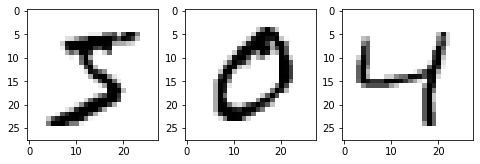

In [ ]:
plot_triplet(x_train[:3])

### A Batch of Triplets

CPU times: user 7.79 ms, sys: 3.81 ms, total: 11.6 ms
Wall time: 11.2 ms


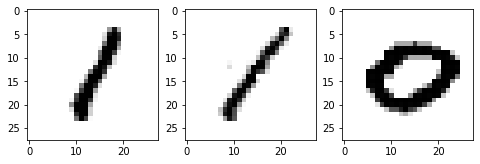

In [ ]:
def generate_batch(batch_size):
    random_indices = np.random.choice(np.array(range(60000)), batch_size)
    random_classes = y_train[random_indices]
    random_choices_pos = []
    random_choices_neg = []
    for c in random_classes:
        random_choices_ = y_train == c
        random_choices_pos.append(np.random.choice(np.squeeze(np.where(random_choices_)), 1))
        random_choices_neg.append(np.random.choice(np.squeeze(np.where(~random_choices_)), 1))
    random_choices_pos = np.array(random_choices_pos).reshape(-1,)
    random_choices_neg = np.array(random_choices_neg).reshape(-1,)
    
    anchors = x_train[random_indices]
    positives = x_train[random_choices_pos]
    negatives = x_train[random_choices_neg]
    
    return [anchors, positives, negatives]

%time batch = generate_batch(1)
plot_triplet(batch)
# len(batch[0][0])

### Embedding Model

In [ ]:
emb_dim = 128

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
Total params: 58,560
Trainable params: 58,560
Non-trainable params: 0
_________________________________________________________________


### Siamese Network

In [ ]:
in_anc = tf.keras.layers.Input((784,))
in_pos = tf.keras.layers.Input((784,))
in_neg = tf.keras.layers.Input((784,))

emb_anc = embedding_model(in_anc)
emb_pos = embedding_model(in_pos)
emb_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([emb_anc, emb_pos, emb_neg], axis=1)

model = tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          58560       input_1[0][0]                    
                                                                 input_2[0][0]         

<center>

### Triplet Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$
</center>

In [ ]:
def triplet_loss(alpha = .2, emb_dim = 128):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
        return tf.maximum(dp - dn + alpha, 0.)
    return loss

### Data Generator

In [ ]:
def data_generator(batch_size = 1024, emb_dim = 128):
    while True:
        x = generate_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
#         print(x.shape)
        yield x, y

### Model Training

In [ ]:
batch_size = 1024
epochs = 10
steps_per_epoch = int(60000/epochs)

model.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_dim), optimizer='adam')

X, Y = x_test[:1000], y_test[:1000]

In [ ]:
hist = model.fit(
    data_generator(batch_size, emb_dim),
    epochs = epochs, steps_per_epoch = steps_per_epoch,
#     verbose = False,
    callbacks = [
        PCAPlotter(plt, embedding_model, X, Y)
    ]
)

Epoch 1/10
 256/6000 [>.............................] - ETA: 50:34 - loss: 0.0659